In [1]:
import nltk # 텍스트 데이터를 처리
import numpy as np # 말뭉치를 배열로 표현
import random
import operator
import re

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


from datetime import datetime
import matplotlib.pyplot as plt

from google.colab import drive

## 2. 라벨링

In [2]:
import os
import numpy as np

drive.mount('/content/drive')


def loadfile(path):
    X = []
    Y = []
    label_map = {'0': 0, '25': 1, '50': 2, '75': 3, '100': 4}
    for label in label_map.keys():
        label_path = os.path.join(path, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.txt'):
                with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                Y.append(label_map[label])
                X.append(text)
    return np.array(X), np.array(Y)

# 경로를 구글 드라이브 경로로 변경
directory_path = '/content/drive/MyDrive/likeability_final/'

# loadfile 함수 호출
X, Y = loadfile(directory_path)

Mounted at /content/drive


In [3]:
# X,Y 차원 확인
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (1577,)
Y shape: (1577,)


In [4]:
## 파일 갯수 확인

def count_txt_files(path):
    file_counts = {}

    for label in ('0', '25', '50', '75', '100'):
        label_path = os.path.join(path, label)
        txt_files = [filename for filename in os.listdir(label_path) if filename.endswith('.txt')]
        file_counts[label] = len(txt_files)

    return file_counts

# .txt 파일 수 확인
file_counts = count_txt_files(directory_path)

# 결과 출력
for label, count in file_counts.items():
    print(f"Number of .txt files in label {label}: {count}")

Number of .txt files in label 0: 365
Number of .txt files in label 25: 300
Number of .txt files in label 50: 305
Number of .txt files in label 75: 303
Number of .txt files in label 100: 304


## 3. 데이터 전처리

In [5]:
# 3-1. 이모지 사용량에 따른 호감도 증가 함수
import re
import numpy as np

# 이모지 카운트 함수
def count_emojis(text):
    emoji_pattern = re.compile('['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        ']', flags=re.UNICODE)
    return len(emoji_pattern.findall(text))

# 호감도 라벨링 함수
def label_likeability(text):
    emoji_count = count_emojis(text)
    exclamation_question_count = len(re.findall(r'[!?]', text))
    a_contributions = len(re.findall(r'A:', text))

    # "A"의 발화에 대한 디폴트 호감도 설정
    likeability = 75 if a_contributions > 0 else 0

    # 이모지 사용에 따른 추가적인 호감도 조정
    if emoji_count == 0 and exclamation_question_count == 0:
        likeability = 0
    elif emoji_count == 0 and exclamation_question_count >= 2:
        likeability = 25
    elif emoji_count == 1:
        likeability = 50 if exclamation_question_count >= 2 else 75
    elif emoji_count >= 2:
        likeability = 100

    return likeability

# 예시 텍스트를 사용하여 함수 테스트
example_text = """A: 안녕! 😀
B: 안녕! 😊
A: 오늘 날씨 어때? 🌤️"""
likeability = label_likeability(example_text)
print("호감도 라벨:", likeability)

호감도 라벨: 100


In [6]:
# 3-2. 답장 속도 기반 호감도 예측
from datetime import datetime
import re
import numpy as np
# 대화 데이터를 .txt 파일에서 불러오기
conversation = []
for label in ('0', '25', '50', '75', '100'):
    label_path = os.path.join(directory_path, label)
    for filename in os.listdir(label_path):
        if filename.endswith('.txt'):
            with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                conversation.extend(file.readlines())


# 대화 데이터를 기반으로 호감도 레이블 생성 함수
def create_likeability_labels(conversation, X):
    response_times = []
    last_message_time = None
    likeability_labels = []

    for line, label in zip(conversation, X):
        if line.startswith("A:") or line.startswith("B:"):
            # 시간 정보 추출 및 변환
            time_str = re.search(r'\((\d{2}):(\d{2})\)', line)
            if time_str:
                hours, minutes = map(int, time_str.groups())
                current_time = hours * 60 + minutes  # Convert to minutes
                # 답장 속도 계산
                if last_message_time is not None:
                    response_time = current_time - last_message_time
                    response_times.append(response_time)
                last_message_time = current_time
        else:
            # 호감도 레이블 생성
            likeability = label_likeability(line)  # 이전에 정의한 label_likeability 함수를 사용
            likeability_labels.append(likeability)

    # X와 같은 크기의 호감도 레이블 생성
    likeability_labels = likeability_labels[:len(X)]

    return likeability_labels

# 대화 데이터를 기반으로 호감도 레이블 생성
likeability_labels = create_likeability_labels(conversation, X)

# X와 likeability_labels 크기 확인
print("X shape:", X.shape)
print("likeability_labels length:", len(likeability_labels))



X shape: (1577,)
likeability_labels length: 53


In [7]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 디렉토리 경로
data_directory = '/content/drive/MyDrive/likeability_final/'

# 데이터 로드 함수
def load_data(directory):
    X = []
    Y = []
    label_map = {'0': 0, '25': 1, '50': 2, '75': 3, '100': 4}
    for label in label_map.keys():
        label_path = os.path.join(directory, label)
        for filename in os.listdir(label_path):
            if filename.endswith('.txt'):
                with open(os.path.join(label_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read()
                Y.append(label_map[label])
                X.append(text)
    return np.array(X), np.array(Y)

# 데이터 로드
X, Y = load_data(data_directory)

# 데이터 분할 (훈련 데이터와 검증 데이터)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=42)

# 분할된 데이터 크기 확인
print("훈련 데이터 크기:", len(X_train))
print("검증 데이터 크기:", len(X_val))


훈련 데이터 크기: 1103
검증 데이터 크기: 474


In [8]:
import tensorflow as tf
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# DistilBERT 모델 및 토크나이저 로드
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

# 데이터 로드 및 전처리
X_train, y_train = load_data(data_directory) # 훈련 데이터 로드 및 전처리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42) # 검증 데이터로 분할

# BERT 입력 데이터 형식으로 변환
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, return_tensors='tf')
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True, return_tensors='tf')  # 검증 데이터도 처리

# TensorFlow 데이터셋으로 변환
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))  # 검증 데이터셋도 생성

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 모델 훈련
history = model.fit(train_dataset.shuffle(1000).batch(8), epochs=20, batch_size=16, validation_data=val_dataset.batch(16))  # 검증 데이터셋 사용

# 모델 평가
results = model.evaluate(val_dataset.batch(8))  # 검증 데이터셋으로 평가
print("Validation loss, Validation accuracy:", results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/20
138/138 [==============================] - 101s 554ms/step - loss: 1.5299 - accuracy: 0.2783 - val_loss: 1.2994 - val_accuracy: 0.4262
Epoch 2/20
138/138 [==============================] - 79s 571ms/step - loss: 1.2026 - accuracy: 0.4723 - val_loss: 1.2300 - val_accuracy: 0.4367
Epoch 3/20
138/138 [==============================] - 78s 567ms/step - loss: 0.9331 - accuracy: 0.6256 - val_loss: 0.7699 - val_accuracy: 0.7363
Epoch 4/20
138/138 [==============================] - 78s 565ms/step - loss: 0.6770 - accuracy: 0.7706 - val_loss: 0.6194 - val_accuracy: 0.7722
Epoch 5/20
138/138 [==============================] - 78s 566ms/step - loss: 0.5221 - accuracy: 0.8277 - val_loss: 0.5260 - val_accuracy: 0.8122
Epoch 6/20
138/138 [==============================] - 78s 566ms/step - loss: 0.4197 - accuracy: 0.8558 - val_loss: 0.5005 - val_accuracy: 0.8207
Epoch 7/20
138/138 [==============================] - 79s 571ms/step - loss: 0.3387 - accuracy: 0.8894 - val_loss: 0.5986 - val_a

30/30 [==============================] - 11s 315ms/step


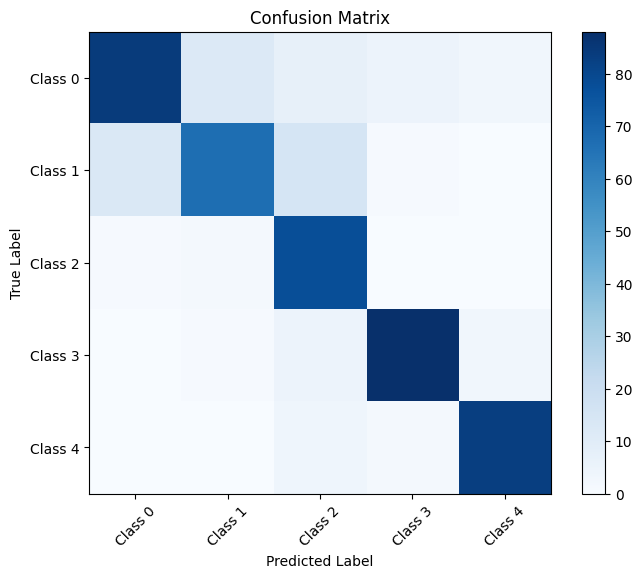

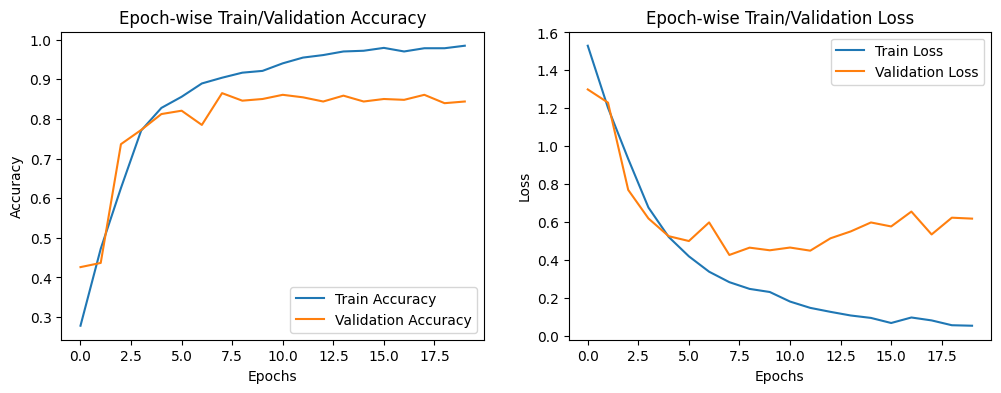

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import time

# 모델 평가
y_pred = model.predict(val_dataset.batch(16))  # 검증 데이터셋에 대한 예측을 수행합니다.

# 혼동 행렬 생성 및 시각화
y_true = y_val
y_pred = np.argmax(y_pred.logits, axis=1)  # 로짓에서 클래스 예측을 얻습니다.
confusion = confusion_matrix(y_true, y_pred)  # 혼동 행렬을 계산합니다.

# 혼동 행렬 그래프
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['0%', '25%', '50%', '75%', '100%']  # 클래스 레이블을 지정합니다.
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Epoch별 Train/Val accuracy 및 loss 시각화 그래프
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch-wise Train/Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch-wise Train/Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [10]:
# 평가 지표 출력
classification_rep = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.86      0.76      0.80       111
     Class 1       0.82      0.70      0.75        96
     Class 2       0.72      0.96      0.82        81
     Class 3       0.92      0.91      0.91        97
     Class 4       0.93      0.93      0.93        89

    accuracy                           0.84       474
   macro avg       0.85      0.85      0.84       474
weighted avg       0.85      0.84      0.84       474



In [11]:
# 모델 크기 계산 (메가바이트)
model_size_bytes = sum(p.numpy().nbytes for p in model.trainable_variables)
model_size_mb = model_size_bytes / (1024 * 1024)
print("Model Size (MB):", model_size_mb)

# 추론 시간 측정
num_samples = len(val_encodings['input_ids'])
inference_start_time = time.time()
model.predict(val_dataset.batch(16))
inference_end_time = time.time()
inference_time_per_sample = (inference_end_time - inference_start_time) / num_samples
print("Inference Time per Sample (s):", inference_time_per_sample)


Model Size (MB): 255.42189407348633
30/30 [==============================] - 10s 318ms/step
Inference Time per Sample (s): 0.020124562681978764
